# Purpose

Calculate MGES Scores for GO terms

In [43]:
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


### Load Brain Cell Type Profiles

In [44]:
path_brain_ctp = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/bulkSimulationOneProfile/data/boot_run_feb29/1/CTProfiles/exp_brain_sc_with_metadata_pc_cpm_cell_type_profiles.csv"
brain_ctp = pd.read_csv(path_brain_ctp, index_col=0)
brain_ctp

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000286098,ENSG00000286106,ENSG00000286112,ENSG00000286190,ENSG00000286219,ENSG00000286237,ENSG00000287542,ENSG00000288602,ENSG00000288649,ENSG00000288675
Astrocytes,32.819733,0.000000,52.635128,21.118639,6.669843,0.000000,2.053207,20.644949,70.065130,11.393249,...,9.037270,19.770655,57.748180,31.514500,8.320486,52.138138,68.117615,38.330547,0.000000,5.076544
Excitatory neurons,1.170022,0.093254,48.352688,21.304518,13.754496,0.216956,0.857144,11.913785,30.244040,6.055134,...,2.241183,1.169713,42.195760,38.369793,4.543709,92.649925,100.205020,32.471050,0.012149,0.688493
Inhibitory neurons,1.227179,0.097602,42.944640,17.141390,13.448284,0.172491,1.483237,15.972332,41.043983,6.860017,...,0.761160,1.093804,46.746693,28.398600,3.828931,101.338160,139.156220,24.477087,0.001229,0.589905
Microglial cells,5.270259,0.000000,55.271400,28.644049,89.148360,20.702814,95.865870,22.505318,67.121254,34.856483,...,11.016589,6.026886,25.544413,26.931417,0.000000,63.942547,171.809880,31.028368,0.000000,0.000000
Oligodendrocyte precursor cells,13.893607,0.000000,30.717295,31.539900,25.565258,1.376305,0.000000,7.081689,45.368656,7.559312,...,9.388611,3.880854,21.299791,19.334665,2.805114,77.494700,88.728810,25.002390,0.000000,1.814200
Oligodendrocytes,0.559028,0.000000,46.318546,19.015804,19.004663,0.427411,0.251452,20.273474,119.014404,17.665918,...,4.943358,0.274065,22.988039,10.256967,0.133372,48.310028,154.988390,25.158625,0.441380,0.109666


### Calculate Cell Type Specificty Scores

A cell type specificty score is a score given for each gene.

It is simply the difference between the largest and second largest expression (CPM) of a gene in cell type profiles. In this case we calculate CTSSs for genes in across brain cells

In [45]:
def one_ctss_diff(series:pd.Series) -> float:
    """Calculate cell type specificity score where it is just the difference in CPM between the top and second highest CPMs

    Args:
        series (pd.Series): CPM of genes across cell types

    Returns:
        float: difference in CPM between top and second top cell type for one gene
    """
    series = series.sort_values(ascending=False)
    
    cts = series.iloc[0]-series.iloc[1]
    return cts

def get_ctss_diff(ctp:pd.DataFrame)-> dict:
    """Calculate CTSS for each gene (column) in a dataframe

    Args:
        ctp (pd.DataFrame): dataframe of cell type profiles, cols are genes rows are cell types

    Returns:
        dict: indexes are genes, values are ctss
    """
    ctp = ctp.T
    
    dic_cts={}
    for gene, gene_profile in ctp.iterrows():
        cts = one_ctss_diff(gene_profile)
        dic_cts[gene]=cts
        
    return dic_cts
        
dic_cts_brain = get_ctss_diff(brain_ctp)

### Calculate MGES Scores for GO terms

Every GO term receives a marker gene enrichment score (MGES)

A MGES score is the mean CTSS score for the GO term's annotated genes.

In [46]:
# Load GO term annotations
go_annot_path = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/preprocessing/preprocessGO_pipe/data/2024_march/data/processing/bp_annotations_withGeneData_qc_annotations.csv"
go_annot = pd.read_csv(go_annot_path)
go_annot.head()

,DB_Object_Symbol,GO ID,Aspect,DB Object Name,ensembl_gene_id,hgnc_symbol,uniprotswissprot,entrezgene_id,description
0,IRGM,GO:0000045,P,Immunity-related GTPase family M protein,ENSG00000237693,IRGM,A1A4Y4,345611.0,immunity related GTPase M [Source:HGNC Symbol;...
1,BECN2,GO:0000045,P,Beclin-2,ENSG00000196289,BECN2,A8MW95,441925.0,beclin 2 [Source:HGNC Symbol;Acc:HGNC:38606]
2,AP4M1,GO:0000045,P,AP-4 complex subunit mu-1,ENSG00000221838,AP4M1,NaN,9179.0,adaptor related protein complex 4 subunit mu 1...
3,ATG13,GO:0000045,P,Autophagy-related protein 13,ENSG00000175224,ATG13,NaN,9776.0,autophagy related 13 [Source:HGNC Symbol;Acc:H...
4,ULK1,GO:0000045,P,Serine/threonine-protein kinase ULK1,ENSG00000177169,ULK1,O75385,8408.0,unc-51 like autophagy activating kinase 1 [Sou...


In [47]:
def mges_all(go_annot:pd.DataFrame, dic_cts:dict)->dict:
	"""Calculate MGES for all GO terms in go_annot. Scales to be 0-1

	Args:
		go_annot (pd.DataFrame): df containig info about what genes are annotated with GO term
		dic_cts (dict): keys are genes, values are CTS scores

	Returns:
		dict: dic containing MGES for all GO Terms. keys are GO term, vals are MGES
	"""
	dic_mges = {}
	for go, go_df in go_annot.groupby("GO ID"):
		mges = mges_one(go_df, dic_cts)
		dic_mges[go]=mges
	# Scale from 0-1
	scaler = MinMaxScaler()
	scaled_mges =  scaler.fit_transform(np.array(list(dic_mges.values())).reshape(-1, 1))
	# Convert the scaled values back to a dictionary
	dic_scaled_mges = {key: float(scaled_mges[i]) for i, key in enumerate(dic_mges.keys())}
	return dic_scaled_mges

def mges_one(go_df:pd.DataFrame, dic_cts:dict)->float:
	"""Calculate the MGES for one GO term by taking the mean of the CTS scores for the genes in the GO Term

	Args:
		go_df (pd.DataFrame): df containing info about the genes in the GO term
		dic_cts (dict): keys are genes, values are CTS scores

	Returns:
		float: MGES for GO term
	"""
	lo_gene_ids = go_df.loc[:,'ensembl_gene_id'].values
	lo_cts_scores = [] # list to hold all cts scores in go term
	for gene_id in lo_gene_ids:
		cts = dic_cts.get(gene_id)
		if cts:
			lo_cts_scores.append(cts)
	return np.mean(lo_cts_scores)
	
dic_MGES_brain = mges_all(go_annot, dic_cts_brain)
dic_MGES_brain

/tmp/ipykernel_1040931/3840235038.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dic_scaled_mges = {key: float(scaled_mges[i]) for i, key in enumerate(dic_mges.keys())}


{'GO:0000045': 0.05454844640208019,
 'GO:0000070': 0.01218149875645625,
 'GO:0000077': 0.03683318028569175,
 'GO:0000079': 0.0352723957587007,
 'GO:0000082': 0.08170457314388647,
 'GO:0000086': 0.19821502589535486,
 'GO:0000132': 0.06863526935877101,
 'GO:0000165': 0.2460453193897252,
 'GO:0000184': 0.04099032998006181,
 'GO:0000209': 0.10576426108695501,
 'GO:0000226': 0.20721976278188714,
 'GO:0000245': 0.03501648640123422,
 'GO:0000278': 0.0447390476242889,
 'GO:0000281': 0.14318834567434724,
 'GO:0000289': 0.10639319533477914,
 'GO:0000375': 0.041414574248594876,
 'GO:0000380': 0.08362453039451337,
 'GO:0000381': 0.20130299877703578,
 'GO:0000387': 0.0066454976287085975,
 'GO:0000398': 0.04270091006424921,
 'GO:0000413': 0.025620461085120713,
 'GO:0000422': 0.03656936389380005,
 'GO:0000423': 0.05983910399349164,
 'GO:0000462': 0.02148698207263432,
 'GO:0000723': 0.05489839205620723,
 'GO:0000724': 0.05283801994653086,
 'GO:0000902': 0.19099060923968553,
 'GO:0001501': 0.1513588246

### Save CTS and MGES json

In [48]:
os.makedirs('data', exist_ok=True)
with open("data/brain_cts.json", "w+") as json_file:
	json.dump(dic_cts_brain, json_file)

with open("data/brain_mges.json", "w+") as json_file:
	json.dump(dic_MGES_brain, json_file)

### Do the same for PBMC

In [49]:
path_pbmc_ctp = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/bulkSimulationOneProfile/data/boot_run_feb29/1/CTProfiles/exp_pbmc_sc_with_metadata_pc_cpm_cell_type_profiles.csv" # for PBMC
pbmc_ctp = pd.read_csv(path_pbmc_ctp, index_col=0)
dic_cts_pbmc = get_ctss_diff(pbmc_ctp)
dic_MGES_pbmc = mges_all(go_annot, dic_cts_pbmc)
os.makedirs('data', exist_ok=True)
with open("data/pbmc_cts.json", "w+") as json_file:
	json.dump(dic_cts_pbmc, json_file)

with open("data/pbmc_mges.json", "w+") as json_file:
	json.dump(dic_MGES_pbmc, json_file)

/tmp/ipykernel_1040931/3840235038.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dic_scaled_mges = {key: float(scaled_mges[i]) for i, key in enumerate(dic_mges.keys())}


# Correlate PBMC and Brain MGES

Text(0, 0.5, 'PBMC MGES')

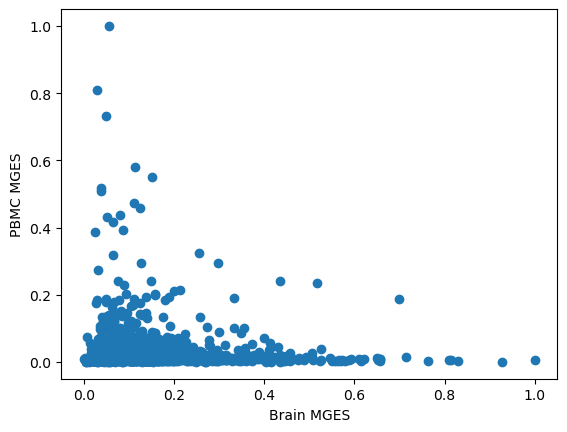

In [50]:
plt.scatter(x = dic_MGES_brain.values(), y = dic_MGES_pbmc.values())
plt.xlabel("Brain MGES")
plt.ylabel("PBMC MGES")

In [63]:
from scipy.stats import spearmanr
# Calculate Spearman's rank correlation
correlation, p_value = spearmanr(list(dic_MGES_brain.values()), list(dic_MGES_pbmc.values()))
print(correlation)
print(p_value)

0.08309847076122719
0.001845119090053606
